In [ ]:
import numpy as np
import math
from enum import Enum
from typing import List
import random

In [ ]:
class TypeActivation(Enum):
  stepFunction = 0
  logisticSigmoid = 1
  hyperbolicTangent = 2
  softmax = 3

In [ ]:
class TypeError(Enum):
  squareError = 0
  crossEntropy = 1

In [ ]:
class Perceptron(object):

  #0 step function, 1 logistic sigmoid, 2 hyperbolic tangent
  def __init__(self, activation: TypeActivation, inputWeights):
    self.__activation = activation
    self.__inWeights = []
    for i in range(inputWeights + 1):
      self.__inWeights.append(random.gauss(0, 1))

  def getActivation(self):
    return self.__activation

  def getInWeights(self):
    return self.__inWeights

  def setInWeights(self, w):
    self.__inWeights = w.copy()

  #outVec is used only when we have the softmax
  def output(self, x, outVec = []):
    #the softmax require two call, one for calculating the output without applayng the softmax and one applaying the softmax
    if not outVec:
      sum = 0
      for i in range(len(self.__inWeights)-1):
        sum +=  self.__inWeights[i]*x[i]
      out = self.__activationFunction(sum+self.__inWeights[-1])
    else:
      out = self.__activationFunction(x, outVec)
    return out

  def __activationFunction(self, u, softmaxIn = []):
    match self.__activation.value:
      case TypeActivation.stepFunction.value:
        return 1 if u>=0 else 0
      case TypeActivation.logisticSigmoid.value:
        return 1/(1 + math.exp(-u))
      case TypeActivation.hyperbolicTangent.value:
        return (math.exp(u) - math.exp(-u))/(math.exp(u) + math.exp(-u))
      case TypeActivation.softmax.value:
        if not softmaxIn:
          return u
        else:
          normalizer = 0
          for i in softmaxIn:
            normalizer += math.exp(i)
          return math.exp(u)/normalizer

In [ ]:
class Model(object):

  def __init__(self, inputDim, activations: List[TypeActivation], neuronsLayer: List[int], errorFun: TypeError):
    self.__layers = len(neuronsLayer)
    self.__neuronsLayer = neuronsLayer
    self.__network = []
    self.__errorType = errorFun
    numNeurons = 0
    for i in range(self.__layers):
      layer = []
      for _ in range(neuronsLayer[i]):
        layer.append(Perceptron(activations[i], inputDim if i==0 else self.__neuronsLayer[i-1]))
      self.__network.append(layer)

  def fit(self, X, y, learningRate, epochs):
    errors = []
    for _ in range(epochs):
      predictions = []
      for i in range(len(X)):
        prediction, actOut = self.predict(X[i])
        predictions.append(prediction)
        self.__backpropagation(actOut, X[i], y[i], learningRate)
      errors.append(self.__error(predictions, y))
    return errors
    #self.__weight = [[0]*(self.__neuronsLayer[0] * len(X[0]))]
    #for i in range(self.__layers - 1):
      #self.__weight.append([0] * (self.__neuronsLayer[i]*self.__neuronsLayer[i+1]))

  def __error(self, y, t):
    err = 0
    print("Target", t)
    print("Predict", y)
    match(self.__errorType.value):
      case TypeError.squareError.value:
        for i in range(len(y)):
          for j in range(len(y[i])):
            err += (y[i][j] - t[i][j])**2
        return err * (1/2)
      case TypeError.crossEntropy.value:
        for i in range(len(y)):
          for j in range(len(y[i])):
            err += (t[i][j] + 1e-10)*math.log(y[i][j] + 1e-10)
        return -err

  def __backpropagation(self, actOut, x, y, learningRate):
    #partial derivative DEn/Daj for each neuron
    theta = []
    for i in range(self.__layers-1, -1, -1):
      rowTheta = []
      for j in range(self.__neuronsLayer[i]):
        th = 0
        #if output layer
        if(i == self.__layers-1):
          th = (actOut[i][j]) - (y[j])
        #if hidden layer
        else:
          #th_j = h'(a_j)*sum k=1 ...neuronsNextLayer (w_kj*th_k)
          for k in range(self.__neuronsLayer[i+1]):
            wk = self.__network[i+1][k].getInWeights()
            th += wk[j] * theta[0][k]
          #calculate derivative of the activation function (h'(a_j))
          if(self.__network[i][j].getActivation().value == TypeActivation.hyperbolicTangent.value):
            th *= (1 - (actOut[i][j])**2)
          elif(self.__network[i][j].getActivation().value == TypeActivation.logisticSigmoid.value or self.__network[i][j].getActivation().value == TypeActivation.softmax.value):
            th *= (actOut[i][j] * (1 - actOut[i][j]))
        rowTheta.append(th)
        #calculate derivativ of the error respect any wights of the neurons ij
        weightsDerivativ = []
        #if the layer is not the first
        if(i != 0):
          for k in range(self.__neuronsLayer[i-1]):
            weightsDerivativ.append(th*actOut[i-1][k])
        else:
          for k in range(len(x)):
            weightsDerivativ.append(th*x[k])
        #bias output = 1
        weightsDerivativ.append(th)
        #applay gradient descent
        newWeights = self.__gradientDescent(self.__network[i][j].getInWeights(), weightsDerivativ, learningRate)
        print("OldWeights", self.__network[i][j].getInWeights())
        print('NewWeights', newWeights)
        self.__network[i][j].setInWeights(newWeights)
      theta.insert(0, rowTheta)


  def __gradientDescent(self, wi, wiDerivativ, learningRate):
    wj = []
    for i in range(len(wi)):
       wj.append(wi[i] + (-learningRate*wiDerivativ[i]))
    return wj

  def predict(self, x):
    actOut = []
    for i in range(self.__layers):
      row = []
      for j in range(self.__neuronsLayer[i]):
        if(i == 0):
          row.append(self.__network[i][j].output(x))
        else:
          row.append(self.__network[i][j].output(actOut[i-1]))
      actOut.append(row)

    #if the softmax we have to applay the softmax to the output w*z
    if(self.__network[-1][0].getActivation().value == TypeActivation.softmax.value):
      row = []
      for i in range(self.__neuronsLayer[-1]):
        row.append(self.__network[-1][i].output(actOut[-1][i], actOut[-1]))
      actOut[-1] = row

    #calculate the binary vector output
    output = []
    if(len(actOut[-1]) > 1):
      maxAct = max(actOut[-1])
      for activation in actOut[-1]:
        if activation == maxAct:
          output.append(1)
        else:
          output.append(0)
    else:
      act = self.__network[-1][0].getActivation().value
      if(act == TypeActivation.logisticSigmoid.value):
        output.append(1 if  actOut[-1][0]>= 0.5 else 0)
      elif(act == TypeActivation.hyperbolicTangent.value):
        output.append(1 if  actOut[-1][0]>= 0 else -1)
      elif(act == TypeActivation.stepFunction.value):
        output.append(1 if  actOut[-1][0]>= 0 else 0)

    print("Activation", actOut)
    return output, actOut

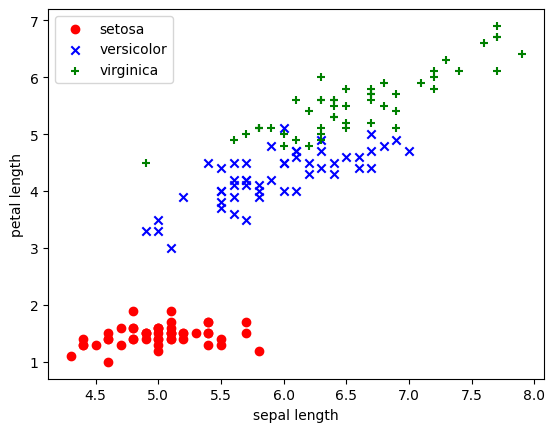

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
df.tail()
y = df.iloc[0:150, 4].values
X = df.iloc[0:150, [0, 2]].values
plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1], color='blue', marker='x', label='versicolor')
plt.scatter(X[100:150, 0], X[100:150, 1], color='green', marker='+', label='virginica')
plt.xlabel('sepal length')
plt.ylabel('petal length')
plt.legend(loc='upper left')
plt.show()

In [ ]:
ppn = Model(X.shape[1], [TypeActivation.logisticSigmoid, TypeActivation.softmax], [5, 3], TypeError.squareError)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Crea un'istanza dell'encoder
encoder = OneHotEncoder()

# Addestra l'encoder e applica la hot encoding al target y
y = encoder.fit_transform(y.reshape(-1, 1)).toarray()
print(y)

In [ ]:
# @title
errors = ppn.fit(X, y, 0.01, 15)

Streaming output truncated to the last 5000 lines.
OldWeights [1.0113991099369959, -1.638941693833885, -0.286532575312648]
NewWeights [1.015938247875212, -1.6374286478544797, -0.28564254826593893]
OldWeights [0.6554935250735164, 0.09648378638277676, -1.0122534688365028]
NewWeights [0.6563006600166187, 0.09675283136381083, -1.0120952070829534]
OldWeights [0.4259200046015158, 0.5882179063705346, 0.29825708718478067]
NewWeights [0.42612505126200895, 0.5882862552573657, 0.29829729241232833]
Activationnn [[0.99932163262909, 0.02756846591770837, 0.8145343046863023, 0.9106809919075931, 0.9695705226039762], [0.5698996866926762, 0.2589176381239052, 0.1711826751834185]]
OldWeights [-1.0616327553671054, -0.4754417157435823, 1.4447309730053095, 0.29354304718011004, -0.1595701563459728, -0.8879320537668519]
NewWeights [-1.0573346698942199, -0.4753231436852962, 1.4482342876017609, 0.29745988897953485, -0.15540003049051765, -0.8836310506337787]
OldWeights [0.9311624927468447, 0.24448647582727764, -0.

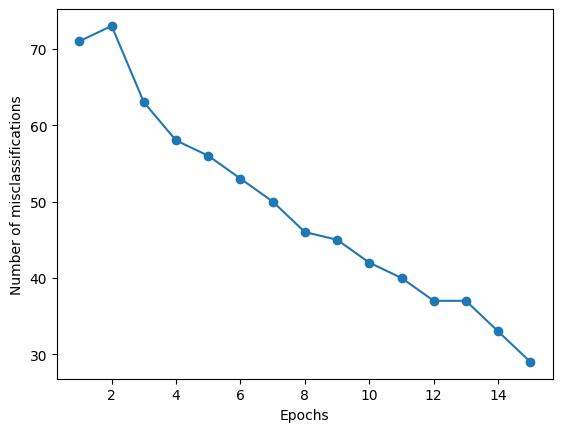

In [ ]:
plt.plot(range(1, len(errors) + 1), errors,marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of misclassifications')
plt.show()

In [ ]:
ppn = Model(X.shape[1], [TypeActivation.hyperbolicTangent, TypeActivation.softmax], [10, 3], TypeError.crossEntropy)

In [ ]:
errors = ppn.fit(X, y, 0.01, 15)

Streaming output truncated to the last 5000 lines.
Activation [[-0.6640845417715405, -0.9999999684933887, -0.999982168446176, -0.9817093489144312, -0.9982133825203718, 0.612894833664687, 1.0, -0.9999999999997113, 0.9999840309397812, 0.9730894598998028], [0.0032403292049128477, 0.07067426184852833, 0.9260854089465588]]
OldWeights [1.9103409515397272, 1.0986579116065411, 0.6344421738296233, 1.1174055765533832, -0.4181327937080946, -0.3377481380148102, -1.8764606719406118, -1.136194342218844, 0.42308774154057793, -1.0674769077810529, 0.6619459049745295]
NewWeights [1.9103624700650794, 1.0986903148975693, 0.6344745765438714, 1.1174373871681236, -0.41810044830833343, -0.3377679978251008, -1.876493075232661, -1.136161938926795, 0.42305533876597895, -1.0675084390830119, 0.6619135016824804]
OldWeights [1.333077953388423, 1.0815866942515686, 0.07084504081537887, -0.9657266316854148, 0.7322187314237977, -1.1523918702661067, 1.646458803566211, 1.672634256085361, -1.0823729489691853, 0.71930144324

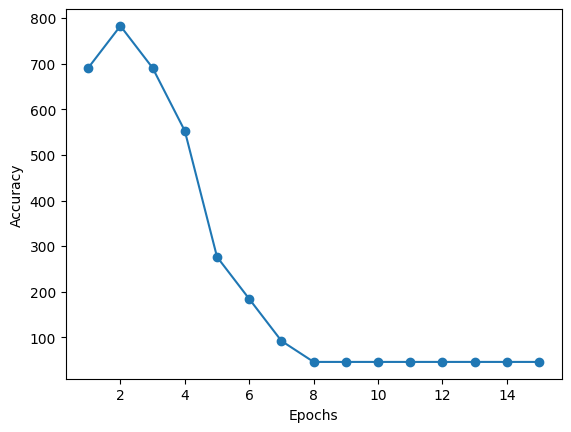

In [ ]:
plt.plot(range(1, len(errors) + 1), errors,marker='o')
plt.xlabel('Epochs')
plt.ylabel('Discrepancy')
plt.show()

In [ ]:
ppn = Model(X.shape[1], [TypeActivation.hyperbolicTangent, TypeActivation.hyperbolicTangent, TypeActivation.softmax], [10,10,3], TypeError.crossEntropy)

In [ ]:
errors = ppn.fit(X, y, 0.01, 15)

Streaming output truncated to the last 5000 lines.
OldWeights [0.6587790279650177, 1.5200406969310813, 0.20029243015890968]
NewWeights [0.6587790279650199, 1.5200406969310831, 0.20029243015890996]
OldWeights [1.1160724820368, 1.017847731414259, -1.9806756961945344]
NewWeights [1.116072482036867, 1.0178477314143175, -1.9806756961945258]
OldWeights [-1.0742799932325884, 0.06874850542663957, -0.9677486884815443]
NewWeights [-1.0742799935966565, 0.06874850510985298, -0.9677486885288259]
Activation [[0.999961786082172, -0.9999993271007596, 0.9043677009539841, 0.999214523516682, -0.9999944424429138, -0.9991613220907914, 0.9765013229159191, 0.9999999998870926, 0.9999999961796449, -0.9999992510121987], [-0.7213071444144874, 0.9999735271627147, 0.9837545675371296, 0.9799556386582422, -0.9999999748690651, -0.9999868256356664, -0.8627805871214242, 0.9537527985736404, 0.9654920565227852, 0.04321620618227665], [0.023630351426468407, 0.09064169962356833, 0.8857279489499633]]
OldWeights [-0.626729897

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
OldWeights [-0.2046201544542965, 0.621349984989948, -0.7647825891109161]
NewWeights [-0.20514982591416278, 0.6211838135515586, -0.7648864462599095]
OldWeights [0.658792446475339, 1.5200457561610348, 0.2002952270939021]
NewWeights [0.6587924365842467, 1.520045753057947, 0.20029522515447223]
OldWeights [1.1166663896275195, 1.0180146511797568, -1.9805504561050906]
NewWeights [1.1166665596663718, 1.018014704525279, -1.980550422764139]
OldWeights [-1.0742380544287626, 0.06875537025175302, -0.9677396409960545]
NewWeights [-1.0742380363248591, 0.06875537593140903, -0.9677396374462695]
Activation [[0.9958938879873882, -0.9968938351908107, -0.898715612542432, 0.9832142451396154, -0.9996638035910432, 0.11305009242960633, -0.6852357009155031, 0.999955698142247, 0.9997902575843398, -0.9999821376588399], [0.565715495450037, 0.915384162220791, 0.9653154043889463, 0.9002672157634047, -0.9992357176593042, -0.9846115386080404, 0.889515245371596, 0.8434

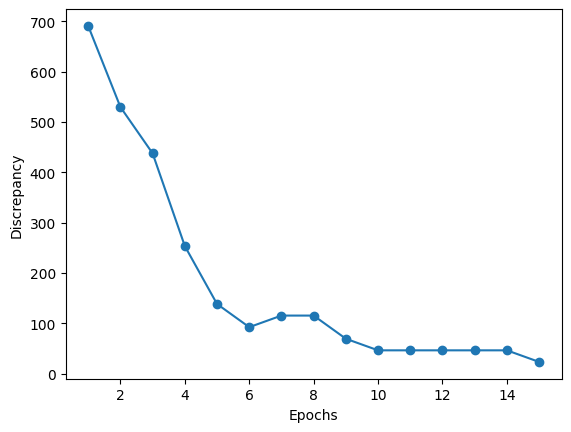

In [ ]:
plt.plot(range(1, len(errors) + 1), errors,marker='o')
plt.xlabel('Epochs')
plt.ylabel('Discrepancy')
plt.show()